# Boxcar extraction with specreduce

This notebook demonstrates a simplified boxcar extraction scenario, using a rectified spectrum in a 2D spectral image where the dispersion axis is the second (X) axis. 

The extraction algorithm in `specreduce` is a plain adaptation of the algorithm presented in the MIRI LRS extraction notebook at https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/MIRI_LRS_spectral_extraction This algorithm is demonstrated separately from the `specreduce` package, in the acompanying notebook http://localhost:8888/notebooks/notebook_sandbox/jwst_boxcar/jwst_boxcar_algorithm.ipynb

Note that the extraction algorithm in the MIRI LRS extraction notebook performs simultaneous background subtraction when extracting from the source. Although it can only subtract the average of the two background extraction boxes. The original extraction code in `specreduce`'s `BoxcarExtract` class was capable of modeling the background with a polynomial along the cross-dispersion direction. This feature was lost in the conversion. 

Note also that we cannot yet perform offline, after-the-fact background subtractions from spectra extracted with `BoxcarExtract`. The reason is that `BoxcarExtract` delivers its `Spectrum1D` product with `spectral_axis` in units of `pixel`. Subsequent operations with such spectra, such as subtraction, are severely limited due to the `pixel` units.

In [1]:
from matplotlib.colors import LogNorm
%matplotlib inline

from pathlib import Path
from zipfile import ZipFile

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import simple_norm
from astropy.utils.data import download_file

from jwst import datamodels

from specreduce.extract import BoxcarExtract
from specreduce.tracing import FlatTrace
from specreduce.background import Background

import os
import tempfile

import numpy as np
import ccdproc

import matplotlib.pyplot as plt
import matplotlib as mpl

## Ingest s2d data

In [2]:
# data is taken from s2d file. x1d is used for comparison with pipeline extraction.
zipped_datapath = Path(download_file('https://stsci.box.com/shared/static/qdj79y7rv99wuui2hot0l3kg5ohq0ah9.zip', cache=True))

data_dir = Path(tempfile.gettempdir())

with ZipFile(zipped_datapath, 'r') as sample_data_zip:
    sample_data_zip.extractall(data_dir)

s2dfile = str(data_dir / "nirspec_fssim_d1_s2d.fits")
x1dfile = str(data_dir / "nirspec_fssim_d1_x1d.fits")

In [3]:
# use a jwst datamodel to provide a good interface to the data and wcs info
s2d = datamodels.open(s2dfile)
image = s2d.slits[0].data

DEBUG:jwst.datamodels.util:Opening /var/folders/gj/z56ys0mx1159ky517lwbwhcr0002vj/T/nirspec_fssim_d1_s2d.fits as <class 'jwst.datamodels.multislit.MultiSlitModel'>


Text(0.5, 1.0, 'slit[0]')

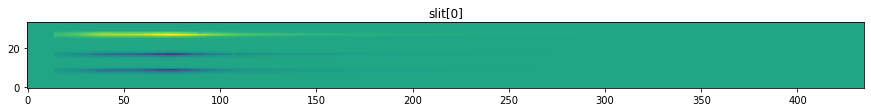

In [4]:
# display s2d image
norm_data = simple_norm(image, "sqrt")
plt.figure(figsize=(15, 15))
plt.imshow(image, norm=norm_data, origin="lower")
plt.title("slit[0]")

<TableColumns names=('WAVELENGTH','FLUX','ERROR','SURF_BRIGHT','SB_ERROR','DQ','BACKGROUND','BERROR','NPIXELS')>


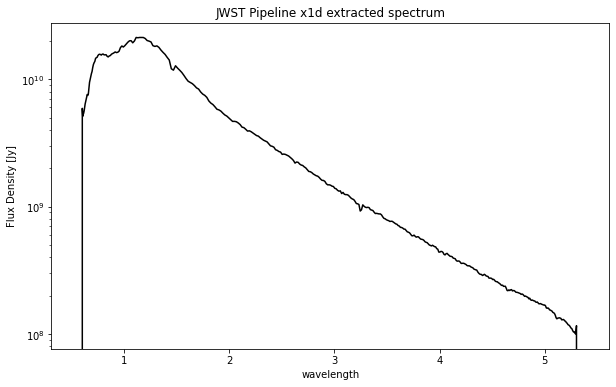

In [5]:
# pipeline 1d extraction (for comparison)
jpipe_x1d = Table.read(x1dfile, hdu=1)
print(jpipe_x1d.columns)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(jpipe_x1d['WAVELENGTH'], jpipe_x1d['FLUX'], 'k-', label="jpipe_x1d")
ax.set_title("JWST Pipeline x1d extracted spectrum")
ax.set_xlabel("wavelength")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")

## Define region to be extracted

At this point, `specreduce` doesn't provide a tool for finding the trace. Since this is rectified data, we can use the `FlatTrace` class and find the spectrum position and width by eye.

Text(0.5, 1.0, 'slit[0] slice')

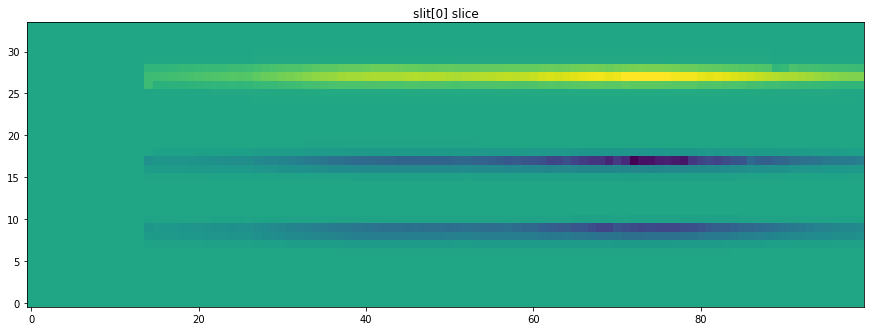

In [6]:
# blow up of the region to be extracted
plt.figure(figsize=(15, 15))
plt.imshow(image[::,0:100], norm=norm_data, origin="lower")
plt.title("slit[0] slice")

In [7]:
# extraction parameters based on image above
ext_center = 27
ext_width = 4

bkg_sep = 4
bkg_width = 2

Text(0.5, 1.0, 'Cross-dispersion Cut at Pixel=70')

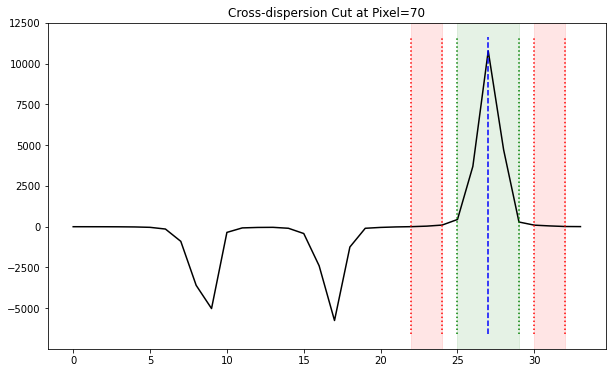

In [8]:
# Plot along cross-disperion cut showing the extraction parameters
fig, ax = plt.subplots(figsize=(10, 6))
y = np.arange(image.shape[0])
ax.plot(y, image[:,70], 'k-')
mm = np.array([ext_center, ext_center])
mm_y = ax.get_ylim()

# extraction region
ax.axvspan(ext_center - ext_width/2., ext_center + ext_width/2., color='green', alpha=0.1)
ax.plot(mm, mm_y, 'b--')
ax.plot(mm - ext_width/2., mm_y, 'g:')
ax.plot(mm + ext_width/2., mm_y, 'g:')

# background region, symmetric on both sides of extraction region
ax.axvspan(ext_center - bkg_sep - bkg_width/2., ext_center - bkg_sep + bkg_width/2., color='red', alpha=0.1)
ax.plot(mm - bkg_sep - bkg_width/2., mm_y, 'r:')
ax.plot(mm - bkg_sep + bkg_width/2., mm_y, 'r:')

ax.axvspan(ext_center + bkg_sep - bkg_width/2., ext_center + bkg_sep + bkg_width/2., color='red', alpha=0.1)
ax.plot(mm + bkg_sep - bkg_width/2., mm_y, 'r:')
ax.plot(mm + bkg_sep + bkg_width/2., mm_y, 'r:')

ax.set_title("Cross-dispersion Cut at Pixel=70")

## Background Subtraction

In [9]:
# extract the background around an estimated Trace
trace = FlatTrace(image, ext_center)
bg = Background(image, trace, separation=bkg_sep, width=bkg_width)

# for the case of a FlatTrace, the central value can be passed directly instead
bg = Background(image, ext_center, separation=bkg_sep, width=bkg_width)

In [10]:
# access the underlying weight image
bg.bkg_wimage.shape

(34, 435)

Text(0.5, 1.0, 'slit[0] slice')

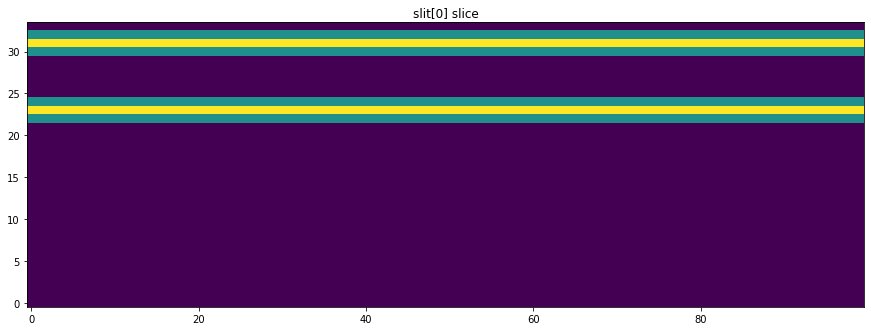

In [11]:
plt.figure(figsize=(15, 15))
plt.imshow(bg.bkg_wimage[::,0:100], origin="lower")
plt.title("slit[0] slice")

In [12]:
bg.bkg_image(image).shape

(34, 435)

In [13]:
bg.sub_image(image).shape

(34, 435)

In [14]:
# identical to calling bg.sub_image(image)
(image - bg).shape

(34, 435)

Text(0.5, 1.0, 'slit[0] slice')

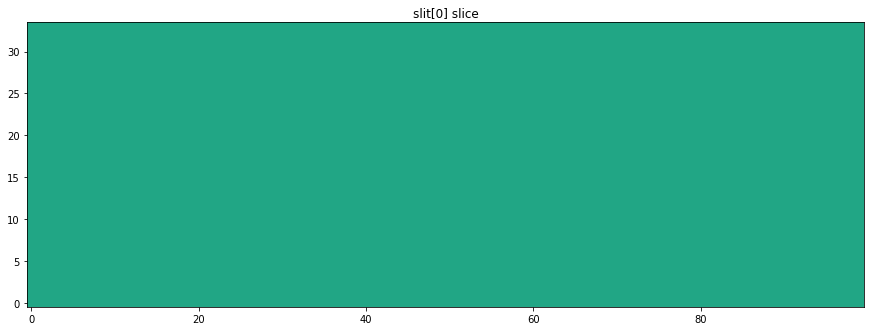

In [15]:
plt.figure(figsize=(15, 15))
plt.imshow(bg.bkg_image(image)[::,0:100], norm=norm_data, origin="lower")
plt.title("slit[0] slice")

Text(0.5, 1.0, 'slit[0] slice')

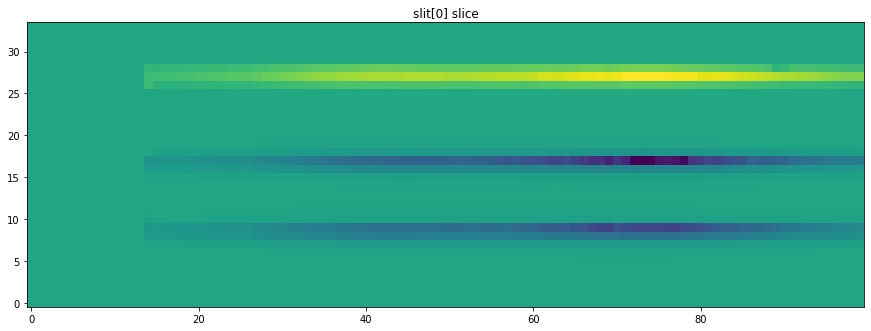

In [16]:
plt.figure(figsize=(15, 15))
plt.imshow(bg.sub_image(image)[::,0:100], norm=norm_data, origin="lower")
plt.title("slit[0] slice")

## Trace

In [17]:
# optional: refine the trace on the background subtracted image (once PR#85 is merged)
#auto_trace = KosmosTrace(image-bg, ...)

## Extract

In [18]:
# extract
boxcar = BoxcarExtract()
spectrum = boxcar(image-bg, trace, width=ext_width)

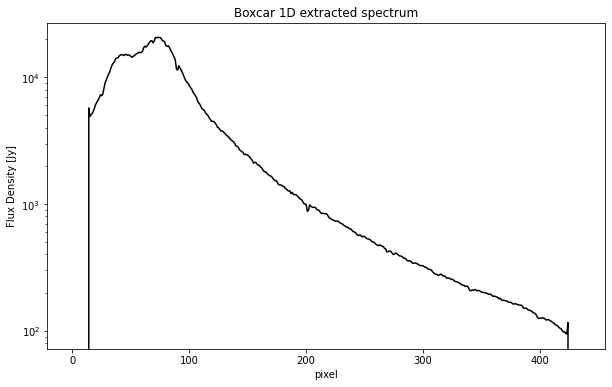

In [19]:
# plot 
f, ax = plt.subplots(figsize=(10, 6))
ax.plot(spectrum.flux.value, 'k-')
ax.set_title("Boxcar 1D extracted spectrum")
ax.set_xlabel(r"pixel")
ax.set_ylabel("Flux Density [Jy]")
ax.set_yscale("log")

## About this notebook

**Author:** Ivo Busko, JWST
**Updated On:** 2022-02-18

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 